## Load Libraries

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, average_precision_score
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt 

import torch
from torchvision import transforms
import torchvision.models as models

from PIL import Image

In [259]:
RANDOM_SEED = 42
CV_FOLD = 5
MAX_ITER = 10000
ENCODING_METHOD = 'vgg'
REDUCE_DIM = True

**Inpiration for the implementation of logistic regressor**
https://atmamani.github.io/projects/ml/mnist-digits-classification-using-logistic-regression-scikit-learn/

**Inspiration for implementation of XGBoost**
https://gist.github.com/pb111/cc341409081dffa5e9eaf60d79562a03 

## Load Sequence data

In [260]:
peptide_score_file = './data/HLA_B_4002.txt'

def load_peptide_data(infile):

    peptides = list()
    labels = list()

    with open(infile) as f:
        for line in f:
            peptide, score = line.strip().split()
            peptides.append(list(peptide))
            labels.append(float(score))

    return peptides, labels

peptides, labels = load_peptide_data(peptide_score_file)

## OneHot Encoding

In [261]:
def one_hot_encode_peptides(peptides, flatten = True):

    flattened_peptides = np.array(peptides).flatten().reshape(-1, 1)

    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(categories=[list('ACDEFGHIKLMNPQRSTVWY')], sparse_output=False)

    # Transform the peptide sequences into a one-hot encoded format
    one_hot_encoded = encoder.fit_transform(flattened_peptides)

    num_peptides = len(peptides)
    
    if flatten:
        # Reshape back into the original peptide sequence format
        one_hot_encoded = one_hot_encoded.reshape(num_peptides, -1)
        
        return one_hot_encoded

    one_hot_encoded = one_hot_encoded.reshape(num_peptides, len(peptides[0]), -1)

    return one_hot_encoded

## VGG Encoding

In [262]:
amino_acid_full_names = {
    'A': 'alanine', 'R': 'arginine', 'N': 'asparagine', 'D': 'aspartic_acid', 'C': 'cysteine', 
    'E': 'glutamic_acid', 'Q': 'glutamine', 'G': 'glycine', 'H': 'histidine', 'I': 'isoleucine', 
    'L': 'leucine', 'K': 'lysine', 'M': 'methionine', 'F': 'phenylalanine', 'P': 'proline',
    'S': 'serine', 'T': 'threonine', 'W': 'tryptophan', 'Y': 'tyrosine', 'V': 'valine'
}

### Load amino acid depictions

In [263]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(RANDOM_SEED)

In [264]:
#store images in cache to save performance
image_cache = {}

def load_AA_image(img_path, vgg = True):

    if img_path in image_cache:
        return image_cache[img_path]
    
    # Define transformation to do on image
    
    # Maybe not do it, if vgg is not the method
    if vgg:
        transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        transform = transforms.Compose([transforms.ToTensor()])

    image = Image.open(img_path).convert('RGB')
    processed_image = transform(image).unsqueeze(0).to(device)
    
    image_cache[img_path] = processed_image
    
    return processed_image

In [265]:
def vgg_features(amino_acid_full_names, reduce_dim = True):

    # Define VGG model
    vgg16_bn = torch.nn.Sequential(   
    # Use only the convolutionary part
    models.vgg16_bn(pretrained = True).features,
    torch.nn.Flatten()
    )

    vgg16 = vgg16_bn.to(device)
    vgg16.eval()

    vgg_features = []

    for aa in amino_acid_full_names.values():
        # load and preprocess
        img_path = f'./2Dstruc/{aa}.png'
        image = load_AA_image(img_path)

        # Disable gradient calculation
        with torch.no_grad():
            conv_features = vgg16(image)

        vgg_features.append(conv_features.cpu().numpy())

    vgg_features = np.vstack(vgg_features)

    if reduce_dim:

        pca = PCA(random_state=42)
        vgg_features = pca.fit_transform(vgg_features)
        
        aa_features_dict = {}
        for idx, aa in enumerate(amino_acid_full_names.keys()):
            aa_features_dict[aa] = vgg_features[idx, :]

        return aa_features_dict, pca

    # Create dictionary with aa_name:PCA_feature
    aa_features_dict = {}
    for idx, aa in enumerate(amino_acid_full_names.keys()):
        aa_features_dict[aa] = vgg_features[idx, :]

    return aa_features_dict

## Encode pepetides

In [266]:
def Encoder(peptides, aa_features_dict, flatten = True):
    
    encoded_peptides = []

    for peptide in peptides:
        encoded_peptide = []
    
        for aa in peptide:
            encoded_peptide.append(aa_features_dict[aa])
        
        if flatten:
            encoded_peptide = np.array(encoded_peptide).flatten()
        
        encoded_peptides.append(encoded_peptide)

    return np.array(encoded_peptides)

In [267]:
# Encode method
if ENCODING_METHOD == 'onehot':
    encoded_peptides = one_hot_encode_peptides(peptides)

elif ENCODING_METHOD == 'vgg':
    if REDUCE_DIM:
        aa_feature_dict, pca = vgg_features(amino_acid_full_names, reduce_dim=REDUCE_DIM)
    else:   
        aa_feature_dict = vgg_features(amino_acid_full_names, reduce_dim=REDUCE_DIM)

    encoded_peptides = Encoder(peptides, aa_feature_dict)

C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Chuan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Split Data

In [268]:
X_train, X_test, y_train, y_test = train_test_split(encoded_peptides, labels, test_size=0.3, random_state=RANDOM_SEED)
kfold = StratifiedKFold(n_splits=CV_FOLD, shuffle=True, random_state=RANDOM_SEED)

## Logistic classifier

In [269]:
# Define the parameter grid
param_grid = {
'C': [0.01, 0.1, 1, 10, 100],
'penalty': ['l1', 'l2'],
'solver': ['liblinear', 'saga'],
'class_weight': [None, 'balanced'],
}

model = LogisticRegression(max_iter=MAX_ITER, random_state=RANDOM_SEED)

gridCV = GridSearchCV(model, param_grid, cv=CV_FOLD, n_jobs=4, verbose=1)

best_log_clf = []

for i, (train_idx, test_idx) in enumerate(kfold.split(X_train, y_train), 1):
    print(f'Fold {i}/{CV_FOLD}')

    gridCV.fit(X_train[train_idx], np.array(y_train)[train_idx])

    best_log_clf.append(gridCV.best_estimator_)

    print(f'Accuracy: {gridCV.best_score_:.4f}')    

# Voting classifier
ensembl_clf = VotingClassifier(estimators=[('clf'+str(i), clf) for i, clf in enumerate(best_log_clf)], voting='soft')
ensembl_clf.fit(X_train, y_train)

Fold 1/5
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.9591
Fold 2/5
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.9540
Fold 3/5
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.9540
Fold 4/5
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.9526
Fold 5/5
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Accuracy: 0.9564


VotingClassifier(estimators=[('clf0',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('clf1',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('clf2',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('clf3',
                              LogisticRegression(C=0.1, max_iter=10000,
                                                 penalty='l1', random_state=42,
                                                 solver='liblinear')),
                             ('clf4',
                              LogisticRegression(C=0.01, max_iter=10000,
                                                 random_state=42,
                                                 solver='saga'))],
                 voting='soft')

In [270]:
y_pred = ensembl_clf.predict(X_test)
log_report = classification_report(y_test, y_pred, digits=4)
print(log_report)

              precision    recall  f1-score   support

         0.0     0.9736    0.9808    0.9772       939
         1.0     0.9135    0.8837    0.8983       215

    accuracy                         0.9627      1154
   macro avg     0.9435    0.9323    0.9378      1154
weighted avg     0.9624    0.9627    0.9625      1154



## XGBoost

In [271]:
# Parameter grid
param_grid = {
    'objective':['binary:logistic'],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200],
    'alpha': [0, 10, 20]
}

model = XGBClassifier(random_state = RANDOM_SEED)

# Perform grid search
grid_search = GridSearchCV(model, param_grid, cv=CV_FOLD, n_jobs=4, verbose=1)
grid_search.fit(X_train, y_train)
best_xgb_clf = grid_search.best_estimator_

y_pred = best_xgb_clf.predict(X_test)
xgb_report = classification_report(y_test, y_pred, digits=4)
print(xgb_report)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
              precision    recall  f1-score   support

         0.0     0.9725    0.9798    0.9761       939
         1.0     0.9087    0.8791    0.8936       215

    accuracy                         0.9610      1154
   macro avg     0.9406    0.9294    0.9349      1154
weighted avg     0.9606    0.9610    0.9608      1154



## Plot ROC

Average precision score ensembl logistic: 0.94292
Average precision score xgb: 0.95089


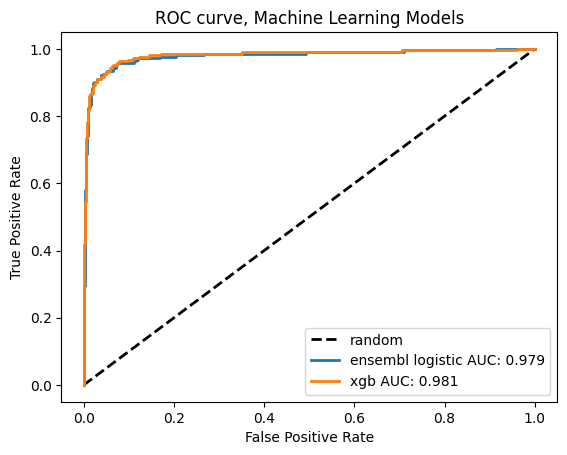

In [273]:
plt.figure()
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--', label='random')

for name, clf in {'ensembl logistic': ensembl_clf, 'xgb': best_xgb_clf}.items(): 
    y_prob = clf.predict_proba(X_test)[::,1]
    print(f'Average precision score {name}: {average_precision_score(y_test, y_prob):.5f}')

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} AUC: {auc_score:.3f}')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve, Machine Learning Models')
plt.legend(loc="lower right");